# 期末報告—預測未來商品銷售量 #


組員：

風管二 107308016 郭家瑜

統計四 105304025 張順益

財政碩二 107255029 陳子晴

財政碩二 107255025 蔡宜樺

分工：

資料清理：郭家瑜、張順益

建置模型：陳子晴、蔡宜樺

期中報告：陳子晴、蔡宜樺

期末報告：郭家榆、蔡宜樺

# 主題介紹及動機

出於對行銷領域及商業分析的好奇心，我們希望能藉助深度學習預測未來銷量，以解決現實世界的營運問題。本次專案中我們擬透過LSTM建構未來銷售量之模型。

資料庫為Kaggle提供，為一日常銷售資料組成的時間序列資料。該資料集由俄羅斯最大的軟體公司之一 — 1C公司提供。

競賽連結：https://www.kaggle.com/c/competitive-data-science-predict-future-sales



# 流程介紹

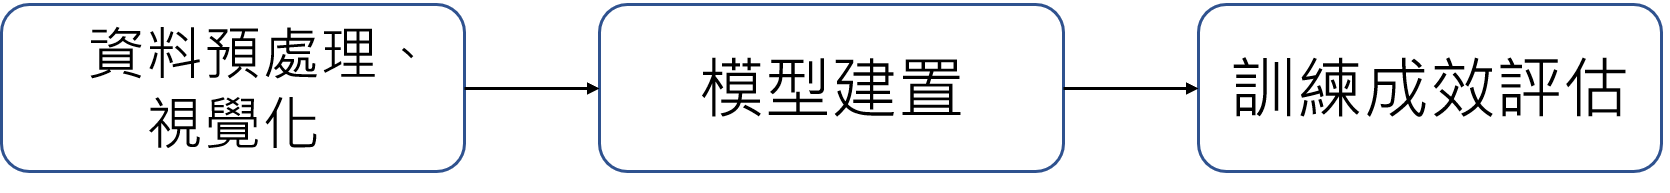

In [20]:
from IPython.display import Image
Image(filename = 'flow.png' , width=1000, height=600)

※資料預處理、視覺化：透過視覺化瞭解整體數據架構後，我們擬將'shop_id', 'item_id', 'item_category_id','Year','Month','item_price'作為x_train，'item_cnt_month'作為y_train。而資料預處理包括填補缺失值、日期格式調整、欄位合併及調整等等。

※模型建置：本次我們使用LSTM建置預測模型。

※訓練成效評估：得到成果後，我們將output上傳至kaggle取得score，並藉由score判斷模型優劣從而調整優化方向。

# 讀入基本套件

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# 載入數據

In [5]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
item = pd.read_csv('items.csv')

# 觀察資料長相

缺失值狀況

In [6]:
print(train.isnull().sum())
print('-------------------')
print(test.isnull().sum())
print('-------------------')
print(item.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
-------------------
ID         0
shop_id    0
item_id    0
dtype: int64
-------------------
item_name           0
item_id             0
item_category_id    0
dtype: int64


觀察資料分布

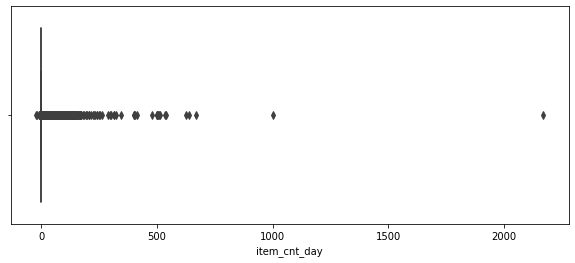

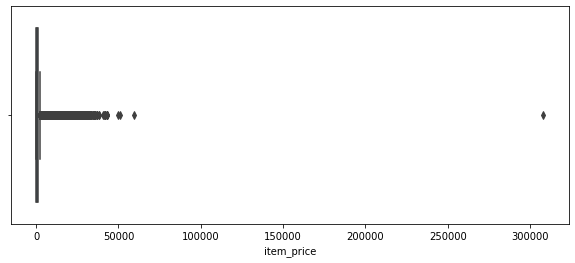

In [7]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_price)

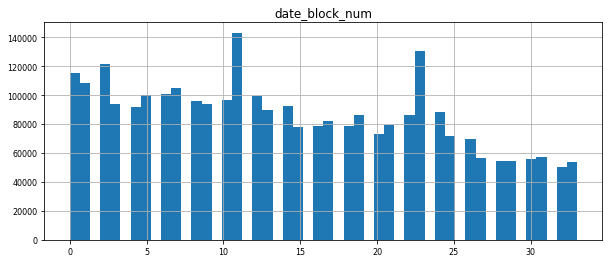

In [8]:
plt.title("date_block_num")
train.date_block_num.hist(figsize=(10, 4), bins=50, xlabelsize=8, ylabelsize=8)

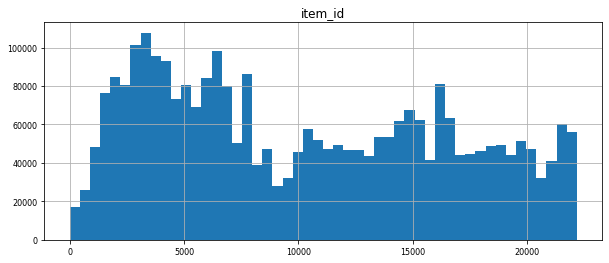

In [9]:
plt.title("item_id")
train.item_id.hist(figsize=(10, 4), bins=50, xlabelsize=8, ylabelsize=8)

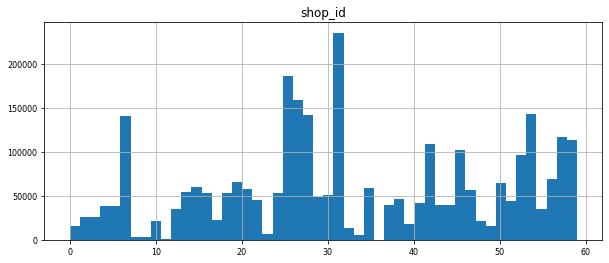

In [10]:
plt.title("shop_id")
train.shop_id.hist(figsize=(10, 4), bins=50, xlabelsize=8, ylabelsize=8)

# 進行訓練資料預處理

除去Outlier：由上方圖表得知，數據中摻有極值，可將其去除。

In [11]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

轉換時間格式。

In [3]:
train['date']=pd.to_datetime(train['date'], format= "%d.%m.%Y")

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
train.shape

(2935849, 6)

In [6]:
train.isnull().sum() #看是否有缺失直

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [7]:
train.sort_values(['date'], inplace = True)

In [8]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2885098,2015-10-31,33,41,21386,169.0,1.0
2930981,2015-10-31,33,21,988,199.0,1.0
2885097,2015-10-31,33,41,21377,169.0,1.0
2930993,2015-10-31,33,22,10207,1199.0,1.0
2928850,2015-10-31,33,24,3042,3199.0,1.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 49800 to 2928850
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.8 MB


In [10]:
train.describe(include = 'all')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00


In [11]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


將月份、年份加入訓練資料：我們的商品和遊戲有關，且商品可能有淡旺月之分，故將月份、年份納入考量。

In [12]:
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year    #將月份以及年份加入資料

In [13]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
2885098,2015-10-31,33,41,21386,169.0,1.0,10,2015
2930981,2015-10-31,33,21,988,199.0,1.0,10,2015
2885097,2015-10-31,33,41,21377,169.0,1.0,10,2015
2930993,2015-10-31,33,22,10207,1199.0,1.0,10,2015
2928850,2015-10-31,33,24,3042,3199.0,1.0,10,2015


In [14]:
train_2 = pd.merge(train,item.iloc[:,1:3],on = 'item_id') #將種類併入資料

In [15]:
train_2.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,item_category_id
0,2013-01-01,0,18,5823,2500.0,1.0,1,2013,35
1,2013-01-01,0,54,5823,2499.5,1.0,1,2013,35
2,2013-01-02,0,54,5823,2500.0,1.0,1,2013,35
3,2013-01-02,0,42,5823,2490.0,1.0,1,2013,35
4,2013-01-02,0,56,5823,2500.0,1.0,1,2013,35


In [16]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   month             int64         
 7   year              int64         
 8   item_category_id  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 224.0 MB


In [17]:
train_2.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
month               0
year                0
item_category_id    0
dtype: int64

為了要預測各個商店各個商品每月銷售量，我們使用groupby分開加總。

In [18]:
train_3 = train_2.groupby(['date_block_num', 'shop_id', 'item_id', 'month', 'year'])['item_cnt_day'].sum() #要預測各個商店各個商品每月銷售量，分開加總

In [19]:
train_3 = train_3.to_frame()
train_3.reset_index(inplace = True)

因為是以每個月為單位，所以將價格取為月的平均。

In [20]:
money = train_2.groupby(['date_block_num', 'shop_id', 'item_id', 'month'])['item_price'].mean() # 因為是每個月所以將價格取為在那個月中的平均

In [21]:
money = money.to_frame()
money.reset_index(inplace = True)

將train_3以及item_price進行合併。

In [22]:
train_3 = pd.concat([train_3, money['item_price']],axis = 1)

In [23]:
train_3.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_day,item_price
0,0,0,32,1,2013,6.0,221.0
1,0,0,33,1,2013,3.0,347.0
2,0,0,35,1,2013,1.0,247.0
3,0,0,43,1,2013,1.0,221.0
4,0,0,51,1,2013,2.0,128.5


我們認為端看item_id並無法明確將產品類型進行劃分，

故使用merge功能，將'item_category_id'納入我們的training data。

In [24]:
train_4 = pd.merge(train_3,item.iloc[:,1:3], on = 'item_id' )
train_4 = train_4.rename(columns= {'item_cnt_day':'item_cnt_month'})

In [25]:
train_4.loc[train_4['year'] == 2013,'year'] =0
train_4.loc[train_4['year'] == 2014,'year'] =1
train_4.loc[train_4['year'] == 2015,'year'] =2 #因為要進行one hot encoding，所以將年份手動進行label encoding

In [26]:
train_4.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_price,item_category_id
0,0,0,32,1,0,6.0,221.0,40
1,0,1,32,1,0,7.0,221.0,40
2,0,3,32,1,0,3.0,349.0,40
3,0,4,32,1,0,2.0,349.0,40
4,0,6,32,1,0,8.0,349.0,40


### 進行模型建構 ###

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [28]:
std = StandardScaler()

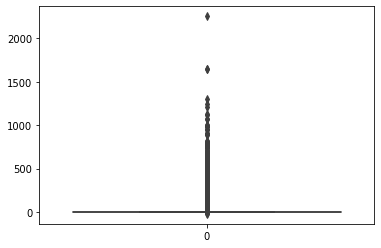

In [29]:
sns.boxplot(data= train_4['item_cnt_month'])

離群值檢測。

In [30]:
Percentile = np.percentile(train_4['item_cnt_month'],[0,25,50,75,100])
IQR = Percentile[3] - Percentile[1]
UpLimit = Percentile[3]+IQR*1.5
DownLimit = Percentile[1]-IQR*1.5

In [31]:
a = train_4['item_cnt_month']>UpLimit 
b = train_4['item_cnt_month']<DownLimit 
train_4 = train_4.loc[(train_4['item_cnt_month']<UpLimit) & (train_4['item_cnt_month']>DownLimit)] 

In [32]:
train_4['item_cnt_month'] = std.fit_transform(train_4['item_cnt_month'].values.reshape(-1,1))
train_4['item_price'] = std.fit_transform(train_4['item_price'].values.reshape(-1,1))
train_4['item_id'] = std.fit_transform(train_4['item_id'].values.reshape(-1,1)) #對數值資料進行標準化

In [33]:
train_4.shape

(1430137, 8)

In [34]:
x_train = train_4[[ 'shop_id', 'item_category_id','month', 'item_price', 'year', 'item_id']]
y_train = train_4['item_cnt_month'].values

In [35]:
x_train.reset_index(drop = True, inplace = True)

In [36]:
x_train1 = to_categorical(x_train['shop_id'])
x_train2 = to_categorical(x_train['item_category_id'])
x_train3 = to_categorical(x_train['month'] )
x_train4 = to_categorical(x_train['year']) #進行one hot encoding

In [37]:
x_train = pd.concat([pd.DataFrame(x_train1), pd.DataFrame(x_train2),pd.DataFrame(x_train3),pd.DataFrame(x_train4), x_train['item_price'], x_train['item_id']], axis = 1)

In [38]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8,9,10,11,12,0,1,2,item_price,item_id
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.273608,-1.743678
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.273608,-1.743678
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.273608,-1.743678
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.273608,-1.743678
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.273608,-1.743678


In [39]:
x_train = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))

In [40]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

In [41]:
model = Sequential()
model.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               148992    
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 161,993
Trainable params: 161,993
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_train, y_train, batch_size = 100, epochs = 15, validation_data=(x_validation, y_validation))

Train on 1144109 samples, validate on 286028 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
1144109/1144109 [==============================] - 96s 84us/sample - loss: 0.9442 - val_loss: 0.9331
Epoch 2/15
1144109/1144109 [==============================] - 88s 77us/sample - loss: 0.9326 - val_loss: 0.9257
Epoch 3/15
1144109/1144109 [==============================] - 88s 77us/sample - loss: 0.9274 - val_loss: 0.9213
Epoch 4/15
1144109/1144109 [==============================] - 90s 78us/sample - loss: 0.9242 - val_loss: 0.9241
Epoch 5/15
1144109/1144109 [==============================] - 93s 81us/sample - loss: 0.9219 - val_loss: 0.9247
Epoch 6/15
1144109/1144109 [==============================] - 93s 81us/sample - loss: 0.9199 - val_loss: 0.9182
Epoch 7/15
1144109/1144109 [==============================] - 93s 81us/sample - loss: 0.9185 - val_loss: 0.9192
Epoch 8/15
1144109/1144109 [==============================] - 93s 81u

In [43]:
model.save(r'C:\Users\user\Desktop\data\lstm_model.h5')

In [44]:
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\user\Desktop\data\lstm_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


資料視覺化。

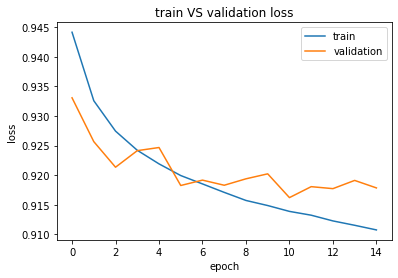

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train VS validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### 測試資料預處理及預測 ###

In [46]:
test['month'] = 11
test['year'] = 2

In [47]:
test.head()

,ID,shop_id,item_id,month,year
0,0,5,5037,11,2
1,1,5,5320,11,2
2,2,5,5233,11,2
3,3,5,5232,11,2
4,4,5,5268,11,2


In [54]:
test_2 = pd.merge(test, item.iloc[:,1:3],on = 'item_id')

In [59]:
test_2.head()

,ID,shop_id,item_id,month,year,item_category_id,item_price
0,0,5,5037,11,2,19,749.500000
1,5100,4,5037,11,2,19,749.333333
2,10200,6,5037,11,2,19,1499.000000
3,15300,3,5037,11,2,19,1499.000000
4,20400,2,5037,11,2,19,749.500000


In [56]:
test_2.isnull().sum()

ID                  0
shop_id             0
item_id             0
month               0
year                0
item_category_id    0
dtype: int64

※處理價格缺失問題：在kaggle所提供的testing data中，有的店家、商品是在training data中尚未出現過的，故可能產生缺失值。因此在本處價格因子我們分兩種情況進行處理：

若是之前有出現過的商品（有歷史資料可考）→ 使用該店該商品的最新價格。
若是之前沒有出現過的商品 → 以商品種類進行劃分，取該種類所有商品的價格平均值。

In [57]:
x = []
for i in range(test_2.shape[0]):
    a = train_2['shop_id'] == test_2.iloc[i,1]
    b = train_2['item_id'] == test_2.iloc[i,2]
    c = train_2['item_category_id'] == test_2.iloc[i,3]
    y = train_2[a & b]['item_price']
    if len(y) != 0:
        x.append(y.iloc[-1])
    elif len(y) == 0:
        y = train_2[b]['item_price']
        if len(y) != 0:
            x.append(y.iloc[-1])
        else:
            x.append(train_2[c]['item_price'].mean())

In [58]:
test_2['item_price'] = x

In [60]:
test_2.to_csv(r'C:\Users\user\Desktop\data\test_2.csv')

In [61]:
test_2 = pd.read_csv(r'C:\Users\user\Desktop\data\test_2.csv')

In [62]:
test_2.sort_values(['ID'], inplace = True)

In [63]:
test_2['item_price'] = std.fit_transform(test_2['item_price'].values.reshape(-1,1))

In [64]:
test_2.head()

,Unnamed: 0,ID,shop_id,item_id,month,year,item_category_id,item_price
0,0,0,5,5037,11,2,19,-0.303574
42,42,1,5,5320,11,2,55,3.032269
84,84,2,5,5233,11,2,19,-0.177962
126,126,3,5,5232,11,2,23,-0.345631
168,168,4,5,5268,11,2,20,3.032269


In [65]:
test1 = to_categorical(test_2['shop_id'])
test2 = to_categorical(test_2['item_category_id'])
test3 = to_categorical(test_2['month'],13 )
test4 = to_categorical(test_2['year'],3 )

In [66]:
test_2['item_price'] = std.fit_transform(test_2['item_price'].values.reshape(-1,1))
test_2['item_id'] = std.fit_transform(test_2['item_id'].values.reshape(-1,1))

In [67]:
test_3 = pd.concat([pd.DataFrame(test1), pd.DataFrame(test2), pd.DataFrame(test3), pd.DataFrame(test4), test_2['item_price'], test_2['item_id']], axis = 1)

In [68]:
test_4 = test_3.values.reshape(test_3.shape[0], 1, test_3.shape[1])

In [69]:
result = model.predict(test_4)

In [70]:
output = pd.concat([test.loc[:,'ID'], pd.DataFrame(result)], axis = 1)

In [71]:
output.head()

,ID,0
0,0,0.097291
1,1,-0.290856
2,2,0.156596
3,3,0.267928
4,4,0.197232


In [72]:
output = output.rename(columns = {0:'item_cnt_month'})

In [ ]:
output['item_cnt_month'] = output['item_cnt_month']-min(output['item_cnt_month'])

#在kaggle competition中有要求最後output值須落在[0,20]

In [74]:
output.to_csv(r'C:\Users\user\Desktop\data\output.csv', index = False)

# 參考資料

* 模型訓練結果可視化：https://cnbeining.github.io/deep-learning-with-python-cn/4-advanced-multi-layer-perceptrons-and-keras/ch15-understand-model-behavior-during-training-by-plotting-history.html
　
* Python機器學習筆記：利用Keras進行多類分類：https://www.itread01.com/content/1536178966.html
　
* 5 Ways to Detect Outliers/Anomalies That Every Data Scientist Should Know (Python Code)：https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

* Predict Future Sales：https://www.kaggle.com/lonewolf45/coursera-final-project?scriptVersionId=28690607